# Workflow for Beer's law results
This document contains the results for a single estimation method of shortwave radiation, namely Beer's law. Expaning this workflow for other estimation methods should be straightforward.

## Goals
* Learn to work with Python and jupyter notebooks
* Set up the workflow for the full analysis to reproduce figure 1 from Clark et al. (2015)

## Workflow
* Load the appropriate .nc file
* Create a Pandas dataframe with time and shortwave radiation estimates
* Calculate the hourly mean estimate for three different time periods
* Plot the resulting typical values throughout a 24-hour day

The time periods are:
* 2005-10-01 to 2006-09-30
* 2006-10-01 to 2007-09-30
* 2007-10-01 to 2008-09-30

## Analysis
### Load data
Define the path:

In [1]:
# Import a function that deals with paths properly, regardless of OS
from pathlib import Path  

# Main folder
dataFolder = Path('C:/Users/wmk934/OneDrive - University of Saskatchewan/Postdoc/SUMMA/summaTestCases_2.1/output/wrrPaperTestCases/figure01')

Find the file names (not really needed here, but prepares the setup of the full script where we do need all these file names):

In [2]:
# Import a library that allows us to check what's in directories
import os 

# Find the .nc files in this folder, but exclude those with 'spinup' in the name
dataFiles = [file for file in os.listdir(dataFolder) if file.endswith('.nc') and not 'spinup' in file]

Load the first .nc file (this contains the results obtained with Beer's law):

In [3]:
# Import a method to load netcdf4 files
from netCDF4 import Dataset

# Open the file
openNcFile = Dataset(os.path.join(dataFolder,dataFiles[0]),'r', format="NETCDF4")

Extract the shortwave radiation estimates along with their simulation time stamps:

In [4]:
# Extract the 'time' variable (also a dimension of the flux variables)
time = openNcFile.variables['time'] # 1 dimension: call the exact values with 'time[:]'' (or simply 'time')

# Extract the `scalarBelowCanopySolar` variable
data = openNcFile.variables['scalarBelowCanopySolar'] # 2 dimensions: 'time' & 'hru'. Call data with 'data[:,0]''

The simulation time stamps are given as 'seconds away from 1990-01-01 0:00:00'. Create a datetime-object that we can use as an index in a Pandas dataframe:

In [16]:
# Import the datetime method
import pandas as pd

# Store the 'time since 1990-01-01' in a temporary array to convert from a numpy masked array to a float (otherwise pd.Timedelta breaks)
time_offset = time[:].data

# Create the full list using the baseline data of 1990-01-01 0:00:00 and the 'time since baseline time information from the .nc file'
time_list = [pd.Timestamp('1990-01-01 0:00:00') 
             + pd.Timedelta(seconds=time_offset[i]) for i in range(0, len(time_offset))]

Store time and data in a Pandas dataframe:

In [22]:
# Create the dataframe
df = pd.DataFrame({'time' : time_list, 
                   'shortwave radiation estimate' : data[:,0]})

# Make sure that 'time' is used as the dataframe index 
df.set_index('time', inplace=True)

# This procedure results in certain rounding errors:
print(df[0:3])

                            shortwave radiation estimate
time                                                    
2005-07-01 00:00:00.000000                           0.0
2005-07-01 00:59:59.999987                           0.0
2005-07-01 02:00:00.000013                           0.0


Round the hours:

In [23]:
# We can use the index functions now to round to whole (H)ours
df.index = df.index.round('H')

# Everything is a round hour now
print(df[0:3])

                     shortwave radiation estimate
time                                             
2005-07-01 00:00:00                           0.0
2005-07-01 01:00:00                           0.0
2005-07-01 02:00:00                           0.0


The data has been prepared. Create a custom function to calculate the hourly mean for a user-specified time period:

In [41]:
# The typical function input should look like: f(dataframe, "2005-10-01", "2006-09-30"))
def calcHourlyMean(data, time_start, time_end):
    
    # Convert inputs to datetime objects
    date_start = pd.Timestamp(time_start)
    date_end = pd.Timestamp(time_end)
    
    # Find which indices are between these dates
    date_use = []
    for i in range(0,len(df.index)):
        if df.index[i] >= date_start and df.index[i] <= date_end:
            date_use.append(i)
            
    # Calculate the hourly means for the period described by the indices
    # Structure: [  select right data  ] [group the data by each hour of 24-h day  ] [mean per group]
    hourlyMean = df[date_start:date_end].groupby(df[date_start:date_end].index.hour).mean()
    
    # Return this value
    return hourlyMean

Extract the data for each of the three periods:

In [44]:
srad_beer_2005_2006 = calcHourlyMean(df, '2005-10-01', '2006-09-30')
srad_beer_2006_2007 = calcHourlyMean(df, '2006-10-01', '2007-09-30')
srad_beer_2007_2008 = calcHourlyMean(df, '2007-10-01', '2008-09-30')

Create a plot that shows these values:

In [45]:
print(srad_beer_2005_2006)

      shortwave radiation estimate
time                              
0                         0.000000
1                         0.000000
2                         0.000000
3                         0.000000
4                         0.000000
5                         0.000000
6                         0.000000
7                         0.000000
8                         0.000000
9                         0.000000
10                        0.000000
11                        0.000000
12                        0.000000
13                        0.000005
14                        5.645756
15                       47.394040
16                       91.446716
17                       93.621879
18                       57.034199
19                       20.316259
20                        1.735360
21                        0.000000
22                        0.000000
23                        0.000000


In [ ]:
srad_

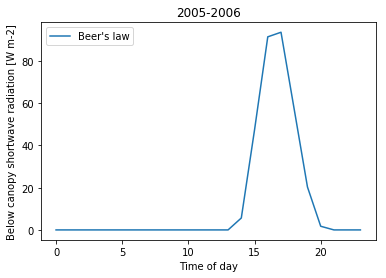

In [54]:
# Import a library that allows plotting
import matplotlib.pyplot as plt

# Create the figure
plt.plot(srad_beer_2005_2006.index, srad_beer_2005_2006['shortwave radiation estimate'], label='Beer\'s law')
plt.xlabel('Time of day')
plt.ylabel('Below canopy shortwave radiation [W m-2]')
plt.title('2005-2006')
plt.legend()
plt.show()

## Things to figure out
* How to store and share data such that specified path remains valid
* More elegant way of handling repeated function calls for different time periods
* Why these results seem so different from this on the paper!

## References
Clark, M. P., B. Nijssen, J. D. Lundquist, D. Kavetski, D. E. Rupp, R. A. Woods, J. E. Freer, E. D. Gutmann, A. W. Wood, D. J. Gochis, R. M. Rasmussen, D. G. Tarboton, V. Mahat, G. N. Flerchinger, D. G. Marks, 2015b: A unified approach for process-based hydrologic modeling: Part 2. Model implementation and case studies. Water Resources Research, doi:10.1002/2015WR017200.